**Numerical Methods Coursework 1**

In [35]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Firstly we define the Kamrad-Ritchken model.

In [22]:

def create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma, N, lamda):
    #model parameters
    
    u=np.exp(lamda*sigma*np.sqrt(dt))
    qu = 1/(2*lamda**2) + ((r - sigma**2/2)*np.sqrt(dt))/(2*lamda*sigma)
    qm = 1-1/lamda**2
    qd = 1/(2*lamda**2) - ((r - sigma**2/2)*np.sqrt(dt))/(2*lamda*sigma)

    if (qu < 0 or qd < 0):
        print("The value of dt is too large and the probabilities will not be viable, please use a smaller value for dt.")
        return

    # Set up the tree via S[n,k] = s0 * u^(k-n)
    prices = np.zeros((N+1, 2*N+1))
    for t in range(N+1):
        prices[t, 0:2*t+1] = s0 * u**np.arange(-t, t+1, 1)

    return (prices, np.array([qd, qm, qu]), u)

    
        

We create an array of prices for $A^n_j$ noticing that these prices have no dependence on $n$.

In [23]:
def create_auxillary_values(s0, N, u):
    indices = np.arange(0,N+1)
    AValues = s0*u**indices
    return AValues

Next we define the funtion for generating the prices by backward induction

In [24]:
def generate_lookback_prices_optimized(s0, r, dt, sigma, N, lamda, american = False):
    Nfloor_div_2 = N//2     
    prices, probabilities, u = create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma,  N, lamda)
    auxillary_values = create_auxillary_values(s0, N, u)
            
    # Option values matrix indexed by time, k, j
    option_values = np.zeros([N+1, 2*N+1, Nfloor_div_2+1])

    # Terminal condition: option values given by terminal payoff

    terminal_stock_price = prices[N]
    k_range = np.arange(0,2*N + 1)
    j_range = np.arange(0, Nfloor_div_2+1)

    #find x such that A^N_{k,j} = S_0u**x indexed by k, j
    #Note this can produce negative indexes, but these represent impossible situations
    #so they will not impact any resulting prices.
    auxiliary_variable_index = (k_range//2)[:,np.newaxis] - Nfloor_div_2 + j_range[np.newaxis, :]
    option_values[N] = np.maximum(np.take_along_axis(auxillary_values[np.newaxis,:], auxiliary_variable_index, axis = 1) - terminal_stock_price[:,np.newaxis], np.zeros(1)[:,np.newaxis])
    
            
    # Backward induction

    # Loop in time
    for n in reversed(range(N)):
               
        #generate the possible values of k_new indexed by current k, stock movement where for the stock movement 0 is down, 1 is no movement, 2 is up.
        current_k = np.arange(0,2*n+1)
        k_new = np.column_stack([current_k, current_k+1, current_k+2])
        floor_k_new_div_2 = k_new//2
        floor_k_div_2 = current_k//2
        j_range = np.arange(0,Nfloor_div_2+1)
        alpha = floor_k_div_2[:, np.newaxis, np.newaxis] + j_range[np.newaxis,:,np.newaxis]
        beta = Nfloor_div_2 + k_new[:,np.newaxis, :] - n - 1

        #Use the shooting function to generate the possible values of jnew indexed by current k, current j, stock movement where for the stock movement 0 is down, 1 is no movement, 2 is up.
        phi_result = -1 * floor_k_new_div_2[:,np.newaxis, :] + np.maximum(alpha, beta)

        #calculate the option prices using backward induction
        continuation_values = (probabilities[0]* np.take_along_axis(option_values[n+1, 0:2*n + 1, :], phi_result[:,:,0], axis = 1) + probabilities[1]* np.take_along_axis(option_values[n+1, 1:2*n + 2, :], phi_result[:,:,1], axis = 1) + probabilities[2]* np.take_along_axis(option_values[n+1, 2:2*n + 3, :], phi_result[:,:,2], axis = 1))

        if american:
            j_range = np.arange(0, Nfloor_div_2+1)

            #find x such that A^n_{k,j} = S_0u**x indexed again by k, j
            auxiliary_variable_index = (np.floor(current_k/2)[:,np.newaxis] - Nfloor_div_2 + j_range[np.newaxis, :]).astype('int')
            current_stock_price = prices[n]
            exercise_values = np.maximum(np.take_along_axis(auxillary_values[np.newaxis,:], auxiliary_variable_index, axis = 1) - current_stock_price[0:2*n + 1,np.newaxis], np.zeros(1)[:,np.newaxis])
            option_values[n][0:2*n+1,0:Nfloor_div_2+1] = np.maximum(exercise_values, np.exp(-1*r*dt)*continuation_values)
        else:
            option_values[n][0:2*n+1,0:Nfloor_div_2+1] =  np.exp(-1*r*dt)*continuation_values

    #print the fair price for the initial time
    return option_values[0,0,Nfloor_div_2]

We include a less optimised version for reference, the output is the same in both cases

In [25]:
def generate_lookback_prices(s0, r, dt, sigma, N, lamda, american = False):
    Ndiv2 = N//2
    prices, probabilities, u = create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma,  N, lamda)
            
    # Option values matrix
    OptPx = np.zeros([N+1, 2*N+1, Ndiv2+1])
    
    
    # Terminal condition: option values given by terminal payoff
    for k in range(2*N+1):
        j_range = np.arange(0, Ndiv2+1)
        OptPx[N, k, j_range] = np.maximum(s0 * u **(k//2 -N//2 + j_range) - prices[N, k], 0)

        

    for n in reversed(range(N)):
 
        # Loop across each stock price index k
        for k in range(2*n+1):
            
            j_range = np.arange(0, N//2+1)
            
            alpha = k//2 + j_range
            phi_up = -1 *((k+2)//2) + np.maximum(alpha, N//2 + (k+2) - n - 1)  
            phi_mid = -1 *((k+1)//2) + np.maximum(alpha, N//2 + (k+1) - n - 1)
            phi_down = -1 * (k//2) + np.maximum(alpha, N//2 + k - n - 1)
            
            V_up = OptPx[n+1, k+2, phi_up]
            V_mid = OptPx[n+1, k+1, phi_mid]
            V_down = OptPx[n+1, k, phi_down]
            
            
            
            # the backward induction step
            if american:
                OptPx[n, k, j_range] = np.maximum(np.maximum(s0 * u **(k//2 -N//2 + j_range) - prices[n, k], 0), np.exp(-1*r*dt)*(probabilities[2]*V_up + probabilities[1]*V_mid + probabilities[0]*V_down))
            else:
                OptPx[n,k,j_range] = np.exp(-1*r*dt)*(probabilities[2]*V_up + probabilities[1]*V_mid + probabilities[0]*V_down)
    return OptPx[0,0,N//2]

*Finally let's run the code to obtain the price

In [50]:
s0 = 100
r = 0.01

sigma = 0.2
N = np.array([1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) 
dt = 1/N
lamda = 1.25


In [51]:
performance_data = pd.DataFrame()

iterations = 20
for american in [True, False]:
    rows = []
    index = []
    for n, d_t in zip(N,dt):
        total_time = 0
        for x in range(iterations):
            start = time.perf_counter()
            price = generate_lookback_prices_optimized(s0, r, d_t, sigma, n, lamda, american)
            stop = time.perf_counter()
            total_time += stop-start
        rows.append([price, total_time/iterations])
        index.append((american, n))
    
    newDataFrame = pd.DataFrame(rows, columns=[ "Value produced", "Running time"], index = pd.MultiIndex.from_tuples(index, names=["American", "Number of iterations"]))
    performance_data = performance_data.append(newDataFrame)

performance_data


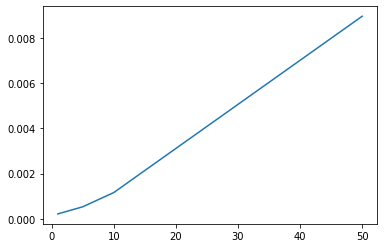

In [47]:
american_data = performance_data.loc[True,:]
plt.plot(american_data["Running time"])


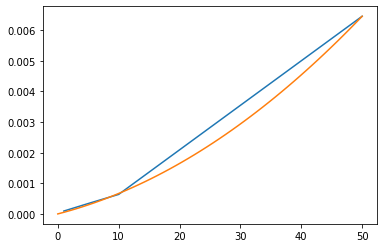

In [49]:
european_data = performance_data.loc[False,:]
plt.plot(european_data["Running time"])
parameters, _ = curve_fit(lambda x,a,b: a*x**2 + b*x, european_data.index, european_data["Running time"], p0 = [1,1])
x = np.linspace(0,N[-1])
y = parameters[0]*x**2 + parameters[1]*x

plt.plot(
    x,
    y)

In [30]:
plt.plot(performance_data['True','1'], performance_data["Running time"])

KeyError: ('True', '1')